# Implementing a GPT model from scratch to generate text


* Coding a GPT-like large language model (LLM)
that can be trained to generate human-like text
* Normalizing layer activations to stabilize neural
network training
* Adding shortcut connections in deep neural
networks
* Implementing transformer blocks to create GPT
models of various sizes
* Computing the number of parameters and
storage requirements of GPT models
* 12 transformers block in GPT2 124M
* To put the scale of our project into perspective, consider the training of the 7 billion parameter Llama 2 model, a relatively popular openly available LLM. This model required 184,320 GPU hours on expensive A100 GPUs, processing 2 trillion tokens. At the time of writing, running an 8 × A100 cloud server on AWS costs around $30 per hour. A rough estimate puts the total training cost of such an LLM at around $690,000 (calculated as 184,320 hours divided by 8, then multiplied by $30).

... it would take 355 years to train GPT-3 (175 billion) on a single V100 datacenter GPU
and 665 years on a consumer RTX 8000 GPU.


In [1]:
GPT_CONFIG_124M = {
"vocab_size": 50257, # Vocabulary size
"context_length": 1024, # Context length
"emb_dim": 768, # Embedding dimension
"n_heads": 12, # Number of attention heads
"n_layers": 12, # Number of layers
"drop_rate": 0.1, # Dropout rate
"qkv_bias": False # Query-Key-Value bias
}

In [2]:
import torch
import torch.nn as nn

In [3]:
class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
        self.pos_emb = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
        self.drop_emb = nn.Dropout(cfg['drop_rate'])
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg['n_layers'])]
        )
        
        self.final_norm = DummyLayerNorm(cfg['emb_dim'])
        self.out_head = nn.Linear(cfg['emb_dim'], cfg['vocab_size'], bias=False)
    
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(
        torch.arange(seq_len, device=in_idx.device)
        )
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
    
    def forward(self, x):
        return x

class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
    def forward(self, x):
        return x

In [4]:
import tiktoken
tokenizer = tiktoken.get_encoding('gpt2')
batch = []
txt1 = 'Every effort moves you'
txt2 = 'Every day holds a'
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [5]:
# Initialize the model 124M
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)


##### Normalizing activations with layer normalization

In [6]:
torch.manual_seed(123)
batch_sample = torch.rand(2, 5)
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_sample)
print(out)

tensor([[0.0000, 0.0000, 0.4091, 0.6587, 0.3914, 0.0000],
        [0.0000, 0.0000, 0.1902, 0.3182, 0.6486, 0.0000]],
       grad_fn=<ReluBackward0>)


In [7]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print('Mean: \n', mean)
print('Variance: \n', var)

Mean: 
 tensor([[0.2432],
        [0.1928]], grad_fn=<MeanBackward1>)
Variance: 
 tensor([[0.0799],
        [0.0670]], grad_fn=<VarBackward0>)


In [8]:
out_norm = (out - mean) / torch.sqrt(var)
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print('Normalized layer outputs: \n', out_norm)
print('Mean:\n', mean)
print('Variance:\n', var)

Normalized layer outputs: 
 tensor([[-0.8603, -0.8603,  0.5869,  1.4698,  0.5242, -0.8603],
        [-0.7450, -0.7450, -0.0102,  0.4844,  1.7608, -0.7450]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[0.0000e+00],
        [9.9341e-09]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.],
        [1.]], grad_fn=<VarBackward0>)


In [9]:
torch.set_printoptions(sci_mode=False)
print('Mean:\n', mean)
print('Variance:\n', var)

Mean:
 tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.],
        [1.]], grad_fn=<VarBackward0>)


In [10]:
# A layer normalization class 

class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift


In [11]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_sample)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)


Mean:
 tensor([[     0.0000],
        [    -0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.9998],
        [0.9999]], grad_fn=<VarBackward0>)


##### Implementing a feed forward network with GELU activations

In [12]:
# GELU activation function
class GELU(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))
        ))

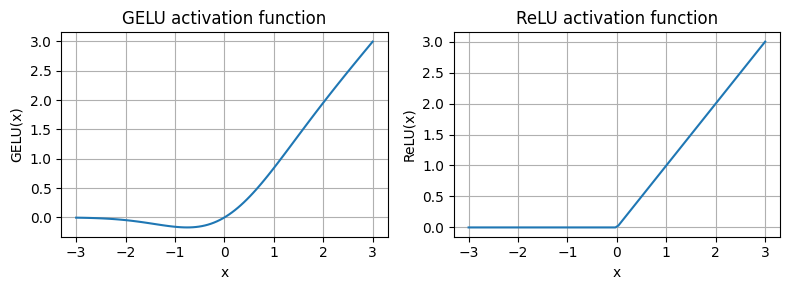

In [13]:
import matplotlib.pyplot as plt
gelu, relu = GELU(), nn.ReLU()

x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)
plt.tight_layout()
plt.show()


In [14]:
# Feedforward nn module
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg['emb_dim'], cfg['emb_dim'] * 4),
            GELU(),
            nn.Linear(cfg['emb_dim'] * 4, cfg['emb_dim'])
        )
    
    def forward(self, x):
        return self.layers(x)

In [15]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768)
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


##### Shortcut Connection (Skip or Residual)

In [16]:
# NN to illustrate shortcut connections
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]),
                          GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]),
                          GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]),
                          GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]),
                          GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]),
                          GELU())
        ])
    
    def forward(self, x):
        for layer in self.layers:
            layer_output = layer(x)
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x     
        

In [17]:
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])

torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)


In [18]:
def print_gradients(model, x):
    output = model(x)
    target = torch.tensor([[0.]])
    loss_fn = nn.MSELoss()
    loss = loss_fn(output, target)
    
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name and param.grad is not None:
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")


In [19]:
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.0001201116101583466
layers.2.0.weight has gradient mean of 0.0007152041653171182
layers.3.0.weight has gradient mean of 0.001398873864673078
layers.4.0.weight has gradient mean of 0.005049646366387606


In [20]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169792652130127
layers.1.0.weight has gradient mean of 0.20694106817245483
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732502937317
layers.4.0.weight has gradient mean of 1.3258541822433472


In [21]:
'''Explanation of the Results

The results show how **shortcut connections** (or their absence) affect the gradients during training.

Results without shortcut (model without shortcut):
- The gradients for the layer weights are **smaller** with minimal variance across layers. 
- This suggests that the model updates weights more slowly and in a more stable manner, which is typical for standard neural networks without shortcut connections.

Results with shortcut (model with shortcut):
- The gradients are significantly **larger**, ranging from 0.2 to 1.3 for different layers.
- This is because **shortcut connections** allow for **easier information flow** between layers, enhancing the **trainability** of the model.
- Larger gradients help the network update weights faster, especially in deep networks.

Conclusion:
- **Without shortcut:** Smaller gradients, possibly slower learning.
- **With shortcut:** Larger gradients, leading to faster training and better information flow in deep networks.'''

'Explanation of the Results\n\nThe results show how **shortcut connections** (or their absence) affect the gradients during training.\n\nResults without shortcut (model without shortcut):\n- The gradients for the layer weights are **smaller** with minimal variance across layers. \n- This suggests that the model updates weights more slowly and in a more stable manner, which is typical for standard neural networks without shortcut connections.\n\nResults with shortcut (model with shortcut):\n- The gradients are significantly **larger**, ranging from 0.2 to 1.3 for different layers.\n- This is because **shortcut connections** allow for **easier information flow** between layers, enhancing the **trainability** of the model.\n- Larger gradients help the network update weights faster, especially in deep networks.\n\nConclusion:\n- **Without shortcut:** Smaller gradients, possibly slower learning.\n- **With shortcut:** Larger gradients, leading to faster training and better information flow i

##### Connecting attention and linear layers in a transformer block

In [22]:
class MultiHeadAttention(nn.Module):
    """
    This class implements multi-head self-attention efficiently. 
    Instead of processing each attention head separately, it uses a single large weight matrix 
    and splits the outputs into multiple heads. This allows for parallel computation, 
    improving speed and reducing memory usage.

    Key features:
    - Uses a single set of weights for query, key, and value projections.
    - Splits the projected values into multiple attention heads.
    - Applies causal masking to prevent information leakage from future tokens.
    - Computes attention in parallel across all heads.
    - Uses an output projection layer to merge information from all heads.

    This implementation is more efficient than stacking multiple single-head attention layers.
    """
    
    def __init__(self, d_in, d_out, 
                 context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            'd_out must be divisible by num_heads'
        
        self.d_out = d_out
        self.num_heads = num_heads
        self.d_head = d_out // num_heads
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            'mask', torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )
        
    def forward(self, x):
        b, num_tokens, d_in = x.shape
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)
        
        keys = keys.view(b, num_tokens, self.num_heads, self.d_head)
        values = values.view(b, num_tokens, self.num_heads, self.d_head)
        queries = queries.view(b, num_tokens, self.num_heads, self.d_head)


        
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)
        
        attn_scores = queries @ keys.transpose(2, 3)
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        
        attn_weights = torch.softmax(attn_scores / keys.shape[-1] ** 0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        context_vec = (attn_weights @ values).transpose(1, 2)
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)
        return context_vec 
        


In [23]:
# transformer block component of GPT

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg['emb_dim'],
            d_out=cfg['emb_dim'],
            context_length=cfg['context_length'],
            num_heads=cfg['n_heads'],
            dropout=cfg['drop_rate'],
            qkv_bias=cfg['qkv_bias'])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg['emb_dim'])
        self.norm2 = LayerNorm(cfg['emb_dim'])
        self.drop = nn.Dropout(cfg['drop_rate'])
    
    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop(x)
        x = x + shortcut
        
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop(x)
        x = x + shortcut
        return x
    

In [24]:
torch.manual_seed(123)
x = torch.rand(2, 5, 768)
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 5, 768])
Output shape: torch.Size([2, 5, 768])


#### Coding the GPT model

In [25]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))

        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


In [26]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)
print(f'vocabulary size of the tokenizer: {50257}')

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.1381,  0.0077, -0.1963,  ..., -0.0222, -0.1060,  0.1717],
         [ 0.3865, -0.8408, -0.6564,  ..., -0.5163,  0.2369, -0.3357],
         [ 0.6989, -0.1829, -0.1631,  ...,  0.1472, -0.6504, -0.0056],
         [-0.4290,  0.1669, -0.1258,  ...,  1.1579,  0.5303, -0.5549]],

        [[ 0.1094, -0.2894, -0.1467,  ..., -0.0557,  0.2911, -0.2824],
         [ 0.0882, -0.3552, -0.3527,  ...,  1.2930,  0.0053,  0.1898],
         [ 0.6091,  0.4702, -0.4094,  ...,  0.7688,  0.3787, -0.1974],
         [-0.0612, -0.0737,  0.4751,  ...,  1.2463, -0.3834,  0.0609]]],
       grad_fn=<UnsafeViewBackward0>)
vocabulary size of the tokenizer: 50257


In [27]:
# number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


In [28]:
# trainable parameters
total_params_gpt2 = (
total_params - sum(p.numel()
for p in model.out_head.parameters())
)
print(f"Number of trainable parameters "
f"considering weight tying: {total_params_gpt2:,}"
)

Number of trainable parameters considering weight tying: 124,412,160


In [29]:
# model size
total_size_bytes = total_params * 4
total_size_mb = total_size_bytes / (1024 * 1024)
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


#### Generating text

This code demonstrates a simple implementation of a generative loop for a lan-
guage model using PyTorch. It iterates for a specified number of new tokens to be
generated, crops the current context to fit the model’s maximum context size, com-
putes predictions, and then selects the next token based on the highest probability
prediction.

In [30]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    '''
    Generates text using a GPT model.

    Parameters:
    - model: The GPT model.
    - idx: The current token sequence (batch, n_tokens).
    - max_new_tokens: Number of new tokens to generate.
    - context_size: Maximum number of tokens used as context.

    Returns:
    - Updated idx with newly generated tokens.
    '''
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]  # Keep only the last context_size tokens
        with torch.no_grad():
            logits = model(idx_cond)  # Get model predictions

        logits = logits[:, -1, :]  # Focus on the last time step
        probas = torch.softmax(logits, dim=-1)  # Convert logits to probabilities
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # Select the most probable token
        idx = torch.cat((idx, idx_next), dim=1)  # Append the new token

    return idx


In [31]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [32]:
model.eval()
out = generate_text_simple(
    model=model,
    idx=encoded_tensor,
    max_new_tokens=6,
    context_size=GPT_CONFIG_124M["context_length"])
print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10


In [33]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text + "\n")
print('! The model is unable to produce coherent text is that we haven’t trained it yet.')

Hello, I am Featureiman Byeswickattribute argue

! The model is unable to produce coherent text is that we haven’t trained it yet.


## Summary

- **Layer normalization** stabilizes training by ensuring that each layer’s outputs have a consistent mean and variance.  
- **Shortcut connections** skip one or more layers, allowing outputs to be fed directly to deeper layers. This helps mitigate the **vanishing gradient problem**, especially in deep neural networks like LLMs.  
- **Transformer blocks** are the core of GPT models, combining **masked multi-head attention** with **fully connected feed-forward networks** that use the **GELU activation function**.  
- **GPT models** are LLMs composed of multiple **repeated transformer blocks**, containing **millions to billions of parameters**.  
- **GPT models come in different sizes**, such as **124M, 345M, 762M, and 1,542M parameters**, all of which can be implemented using the same `GPTModel` Python class.  
- **Text generation in GPT models** involves decoding output tensors into human-readable text by **predicting one token at a time** based on a given input context.  
- **Without training, a GPT model generates incoherent text**, highlighting the necessity of training for coherent text generation.  


## Pretraining on unlabeled data

##### Using GPT to generate text

In [34]:
GPT_CONFIG_124M = {
"vocab_size": 50257,
"context_length": 256,  # original: 1024
"emb_dim": 768,
"n_heads": 12,
"n_layers": 12,
"drop_rate": 0.1,
"qkv_bias": False
}
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out

In [35]:
import torch
import tiktoken

def text_to_token_ids(text, tokenizer):
    """
    Converts a text string into a tensor of token IDs using the specified tokenizer.

    Parameters:
    - text: The input string to tokenize.
    - tokenizer: The tokenizer used to encode the text.

    Returns:
    - A PyTorch tensor containing the token IDs with an added batch dimension.
    """
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)  # Add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    """
    Converts a tensor of token IDs back into a human-readable text string.

    Parameters:
    - token_ids: A tensor containing token IDs.
    - tokenizer: The tokenizer used to decode the token IDs.

    Returns:
    - A decoded text string.
    """
    flat = token_ids.squeeze(0)  # Remove batch dimension
    return tokenizer.decode(flat.tolist())

# Define the initial text input
start_context = "Every effort moves you"

# Load the GPT-2 tokenizer
tokenizer = tiktoken.get_encoding("gpt2")

# Generate new token IDs using the GPT model
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

# Convert generated token IDs back to text and print
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))


Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


##### Calculating the text generation loss

In [36]:
inputs = torch.tensor([[16833, 3626, 6100],  # ["every effort moves",
                          [40, 1107, 588]])  # "I really like"]

In [37]:
targets = torch.tensor([[3626, 6100, 345 ], # [" effort moves you",
                       [1107, 588, 11311]]) # " really like chocolate"]

In [38]:
with torch.no_grad():
    logits = model(inputs)
probas = torch.softmax(logits, dim=-1)
print(probas.shape)

torch.Size([2, 3, 50257])


In [39]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [40]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1:"
f" {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


In [41]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)
text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([    0.0001,     0.0000,     0.0000])
Text 2: tensor([    0.0000,     0.0001,     0.0000])


In [42]:
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


In [43]:
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.7940)


In [44]:
print("Logits shape:", logits.shape)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


In [45]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()
print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


In [46]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.7940)


##### Calculating the training and validation set losses

In [47]:
file_path = 'the-verdict.txt'
with open(file_path, 'r', encoding='utf-8') as file:
    text_data = file.read()

In [48]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print('Characters:', total_characters)
print('Tokens:', total_tokens)

Characters: 20479
Tokens: 5145


In [49]:
train_ratio = 0.9
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

In [50]:
import torch
import tiktoken
from torch.utils.data import DataLoader

class GPTDatasetV1:
    def __init__(self, txt, tokenizer, max_length, stride):
        self.tokenizer = tokenizer
        self.tokens = tokenizer.encode(txt)
        self.max_length = max_length
        self.stride = stride
        self.samples = self._create_samples()

    def _create_samples(self):
        samples = []
        for i in range(0, len(self.tokens) - self.max_length, self.stride):
            input_tokens = self.tokens[i:i + self.max_length]
            target_tokens = self.tokens[i + 1:i + self.max_length + 1]
            samples.append((input_tokens, target_tokens))  # Возвращаем кортеж (входные данные, цель)
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        input_tokens, target_tokens = self.samples[idx]
        return torch.tensor(input_tokens, dtype=torch.long), torch.tensor(target_tokens, dtype=torch.long)

def collate_fn(batch):
    inputs, targets = zip(*batch)  # Разбиваем batch на входные данные и цели
    inputs = torch.stack(inputs)  # Превращаем в батч тензоров
    targets = torch.stack(targets)
    return inputs, targets

def create_dataloader_v1(txt, batch_size=4, max_length=256, stride=128, shuffle=True, drop_last=True, num_workers=0):
    tokenizer = tiktoken.get_encoding("gpt2")  # Инициализация токенизатора
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)  # Создание датасета
    
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        collate_fn=collate_fn  # Добавляем collate_fn для преобразования в тензоры
    )
    
    return dataloader

In [51]:
torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)
val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=False,
    num_workers=0
)

In [52]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)
    
print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [53]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(
    logits.flatten(0, 1), target_batch.flatten()
    )
    return loss

In [54]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.

    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break

    return total_loss / num_batches


In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
val_loss = calc_loss_loader(val_loader, model, device)
print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.987583690219456
Validation loss: 10.98110580444336


##### Training an LLM

Training Process in PyTorch

1. **Loop over epochs** – Full pass through the dataset.
2. **Loop over batches** – Split data into mini-batches.
3. **Zero gradients** – Reset gradients to prevent accumulation:
   ```python
   optimizer.zero_grad()
   ```
4. **Compute loss** – Forward pass and loss calculation:
   ```python
   outputs = model(input_batch)
   loss = loss_function(outputs, target_batch)
   ```
5. **Backpropagation** – Compute gradients:
   ```python
   loss.backward()
   ```
6. **Update weights** – Adjust model parameters:
   ```python
   optimizer.step()
   ```
7. **Print losses** – Monitor training and validation loss.
8. **Generate text (optional)** – Inspect model output:
   ```python
   sample_text = generate_text(model, tokenizer, prompt="AI is")
   print(sample_text)
   ```

In [56]:
# The main function for pretraining LLMs

def train_model_simple(model, train_loader, val_loader,
                        optimizer, device, num_epochs,
                        eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1
    
    for epoch in range(num_epochs):  # Main training loop
        model.train()  
        
        for input_batch, target_batch in train_loader:  # Iterate over batches
            optimizer.zero_grad()  # Reset gradients
            loss = calc_loss_batch(input_batch, target_batch, model, device)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update model weights

            tokens_seen += input_batch.numel()  # Track number of processed tokens
            global_step += 1  

            if global_step % eval_freq == 0:  # Evaluate model at specified intervals
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

                generate_and_print_sample(model, tokenizer, device, start_context)  # Generate sample text

    return train_losses, val_losses, track_tokens_seen


In [57]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()  # Set the model to evaluation mode (disables dropout, batch norm updates)
    
    with torch.no_grad():  # Disable gradient computation to save memory and speed up evaluation
        train_loss = calc_loss_loader(train_loader, model, device,      num_batches=eval_iter)  # Compute train loss
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)  # Compute validation loss

    model.train()  # Set the model back to training mode
    return train_loss, val_loss  # Return computed losses

In [58]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()  # Set model to evaluation mode (disables dropout, batch norm updates)

    context_size = model.pos_emb.weight.shape[0]  # Get the context size from positional embeddings
    encoded = text_to_token_ids(start_context, tokenizer).to(device)  # Encode input text and move to device

    with torch.no_grad():  # Disable gradient tracking for efficiency
        token_ids = generate_text_simple(
            model=model, idx=encoded, 
            max_new_tokens=50, context_size=context_size  # Generate up to 50 new tokens
        )

    decoded_text = token_ids_to_text(token_ids, tokenizer)  # Convert token IDs back to text
    print(decoded_text.replace("\n", " "))  # Print output with newlines replaced for readability

    model.train()  # Switch model back to training mode

In [59]:
torch.manual_seed(123)  # Set random seed for reproducibility
model = GPTModel(GPT_CONFIG_124M)  # Initialize the model with the given configuration
model.to(device)  # Move the model to the appropriate device (CPU or GPU)

# Initialize the optimizer (AdamW with learning rate and weight decay)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.0004,  # Learning rate
    weight_decay=0.1  # Weight decay (L2 regularization)
)

num_epochs = 10  # Number of epochs for training

# Train the model using the simple training loop
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,  # Model, data loaders, optimizer, device
    num_epochs=num_epochs,  # Number of epochs
    eval_freq=5,  # Frequency of evaluation during training (every 5 steps)
    eval_iter=5,  # Number of iterations for evaluation
    start_context="Every effort moves you",  # Initial text for text generation during evaluation
    tokenizer=tokenizer  # Tokenizer used for processing text
)


Ep 1 (Step 000000): Train loss 9.783, Val loss 9.927
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,, the,,,,,,,,,,,,,,,,,,,,
Ep 1 (Step 000005): Train loss 7.985, Val loss 8.335
Every effort moves you, the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
Ep 2 (Step 000010): Train loss 6.753, Val loss 7.048
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ep 2 (Step 000015): Train loss 6.114, Val loss 6.573
Every effort moves you, the to the to the.                                           
Ep 3 (Step 000020): Train loss 5.525, Val loss 6.490
Every effort moves you, and, and the of the of the of the of the of the of the of the of the of the of the of the of the the of the the of the of the of the of the of the of the of the of the of
Ep 3 (Step 000025): Train loss 5.324, Val loss 6.387
Every effort moves you his " to 

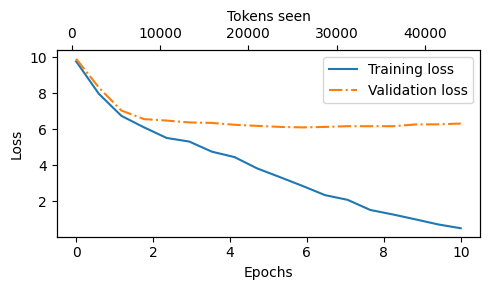

In [60]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Function to plot training and validation losses
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    # Create a figure and axis for plotting
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot the training and validation losses against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    
    # Set the x and y axis labels
    ax1.set_xlabel("Epochs")  # X-axis label for epochs
    ax1.set_ylabel("Loss")  # Y-axis label for loss

    # Display a legend for the plot
    ax1.legend(loc="upper right")
    
    # Ensure that the x-axis ticks are integer values
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

    # Create a second x-axis (top) for tokens seen
    ax2 = ax1.twiny()

    # Plot an invisible line to link the top x-axis (tokens_seen) to the training losses
    ax2.plot(tokens_seen, train_losses, alpha=0)  # alpha=0 makes the line invisible

    # Set the label for the second x-axis (tokens seen)
    ax2.set_xlabel("Tokens seen")

    # Automatically adjust the layout to avoid overlapping labels and elements
    fig.tight_layout()

    # Show the plot
    plt.show()

# Create a tensor for epochs ranging from 0 to num_epochs with the same length as train_losses
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))

# Call the plot_losses function to plot the training and validation losses
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)


The resulting training and validation loss plot is shown in figure 5.12. As we can see, both the training and validation losses start to improve for the first epoch. However, the losses start to diverge past the second epoch. This divergence and the fact that the validation loss is much larger than the training loss indicate that the model is overfitting to the training data. We can confirm that the model memorizes the training data verbatim by searching for the generated text snippets, such as quite insensible to the irony in the “The Verdict” text file.

##### Decoding strategies to control randomness

In [61]:
model.to("cpu")  # Move the model to CPU
model.eval()  # Set the model to evaluation mode

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out

In [62]:
tokenizer = tiktoken.get_encoding("gpt2")  # Initialize the tokenizer
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




Temperature scaling 

In [63]:
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}
inverse_vocab = {v: k for k, v in vocab.items()}

In [64]:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
    )

In [65]:
probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()
print(inverse_vocab[next_token_id])

forward


In [66]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

toward


In [67]:
def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples=1).item()
    for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")
print_sampled_tokens(probas)

71 x closer
2 x every
0 x effort
544 x forward
2 x inches
1 x moves
0 x pizza
376 x toward
4 x you


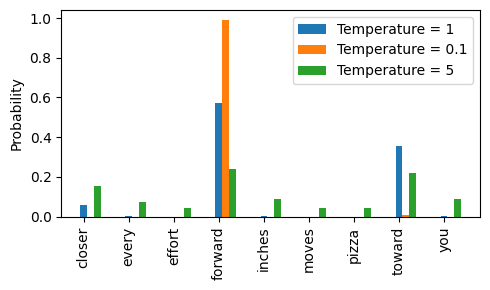

In [72]:
# Define the softmax_with_temperature function
def softmax_with_temperature(logits, temperature):
    """
    Applies softmax to logits with temperature scaling.

    Parameters:
    - logits: Tensor of logits.
    - temperature: Temperature value for scaling.

    Returns:
    - Scaled probabilities after applying softmax.
    """
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

temperatures = [1, 0.1, 5]
scaled_probas = [softmax_with_temperature(next_token_logits, T)
                 for T in temperatures]

x = torch.arange(len(vocab))
bar_width = 0.15
fig, ax = plt.subplots(figsize=(5, 3))

for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i],
                   bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

Top-k sampling

In [74]:
top_k = 3

# Ensure next_token_logits is a tensor
if isinstance(next_token_logits, list):
    next_token_logits = torch.tensor(next_token_logits)

top_logits, top_pos = torch.topk(next_token_logits, top_k)
print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


In [75]:
# Create a mask where values lower than the smallest top-k logit are set to -inf
new_logits = torch.where(
    next_token_logits < top_logits[-1],  # Condition: if value < smallest top-k logit
    torch.full_like(next_token_logits, float('-inf')),  # Assign -inf
    next_token_logits  # Otherwise, keep original value
)

print("Modified logits:", new_logits)

Modified logits: tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [76]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


Modifying the text generation function

In [77]:
def generate(model, idx, max_new_tokens, context_size,
             temperature=0.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]  # Limit the context to the last tokens
        
        with torch.no_grad():
            logits = model(idx_cond)  # Get model predictions
            logits = logits[:, -1, :]  # Focus on the last timestep logits
        
        # Apply top-k filtering
        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, 
                                 torch.full_like(logits, float('-inf')), 
                                 logits)
        
        # Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)  # Sample from probabilities
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # Greedy selection
        
        # Stop generation if end-of-sequence token is reached
        if eos_id is not None and (idx_next == eos_id).all():
            break
        
        idx = torch.cat((idx, idx_next), dim=1)  # Append the new token to the sequence
    
    return idx


In [78]:
torch.manual_seed(123)
token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you know began to my surprise, a little it was the
"Ah enough


##### Loading and saving model weights in PyTorch

In [79]:
torch.save(model.state_dict(), "model.pth")

model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load("model.pth", map_location=device))
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out

In [80]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    },
    "model_and_optimizer.pth"
)

In [81]:
checkpoint = torch.load("model_and_optimizer.pth", map_location=device)
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train();

##### Loading pretrained weights from OpenAI

In [82]:
import urllib.request
url = (
    "https://raw.githubusercontent.com/rasbt/"
    "LLMs-from-scratch/main/ch05/"
    "01_main-chapter-code/gpt_download.py"
)
filename = url.split('/')[-1]
urllib.request.urlretrieve(url, filename)

('gpt_download.py', <http.client.HTTPMessage at 0x1275758b0>)

In [83]:
from gpt_download import download_and_load_gpt2
settings, params = download_and_load_gpt2(
model_size="124M", models_dir="gpt2"
)

2025-04-20 17:03:55.503121: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


In [84]:
print("Settings:", settings)
print("Parameter dictionary keys:", params.keys())

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [85]:
print(params["wte"])
print("Token embedding weight tensor dimensions:", params["wte"].shape)

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions: (50257, 768)


In [86]:
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

In [87]:
model_name = "gpt2-small (124M)"
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024})
NEW_CONFIG.update({"qkv_bias": True})

In [88]:
gpt = GPTModel(NEW_CONFIG)
gpt.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_f

In [89]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, "
                        "Right: {right.shape}"
)
    return torch.nn.Parameter(torch.tensor(right))

In [90]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    
    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"]) ["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)
        
        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"]) ["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)
        
        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])
        
        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])
        
        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"])
    
    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])


In [91]:
load_weights_into_gpt(gpt, params)
gpt.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_f

In [92]:
torch.manual_seed(123)
token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you toward an equal share for each vote plus half. Inequality is often not an accurate representation of human worth; to know the


##### Summary

- When LLMs generate text, they output one token at a time.  
- By default, the next token is generated by converting the model outputs into probability scores and selecting the token from the vocabulary that corresponds to the highest probability score, which is known as “greedy decoding.”  
- Using probabilistic sampling and temperature scaling, we can influence the diversity and coherence of the generated text.  
- Training and validation set losses can be used to gauge the quality of text generated by LLM during training.  

##### Pretraining on Unlabeled Data  

- Pretraining an LLM involves changing its weights to minimize the training loss.  
- The training loop for LLMs itself is a standard procedure in deep learning, using a conventional cross-entropy loss and AdamW optimizer.  
- Pretraining an LLM on a large text corpus is time- and resource-intensive, so we can load openly available weights as an alternative to pretraining the model on a large dataset ourselves.  


## Fine-tuning for classification

In [93]:
import urllib.request
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return
    with urllib.request.urlopen(url) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")

download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

sms_spam_collection/SMSSpamCollection.tsv already exists. Skipping download and extraction.


In [94]:
import pandas as pd

df = pd.read_csv(
data_file_path, sep="\t", header=None, names=["Label", "Text"]
)
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [95]:
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


In [96]:
# Creating a balanced dataset
def create_balanced_dataset(df):
    num_spam = df[df["Label"] == "spam"].shape[0]
    ham_subset = df[df["Label"] == "ham"].sample(
    num_spam, random_state=123
    )

    balanced_df = pd.concat([
    ham_subset, df[df["Label"] == "spam"]
    ])
    return balanced_df

balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


In [97]:
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

In [98]:
# Splitting the dataset 
def random_split(df, train_frac, validation_frac):
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)
    train_end = int(len(df) * train_frac)
    validation_end = train_end + int(len(df) * validation_frac)
    
    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]
    
    return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)

In [99]:
train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

##### Creating data loaders

In [100]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [101]:
# Setting up a Pytorch Dataset class
import torch
from torch.utils.data import Dataset
import pandas as pd

class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)
        
        # Pretokenizes texts
        self.encoded_texts = [tokenizer.encode(text) for text in self.data["Text"]]
        
        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
        
        # Truncates sequences if they are longer than max_length
        self.encoded_texts = [
            encoded_text[:self.max_length] for encoded_text in self.encoded_texts
        ]
        
        # Pads sequences to the longest sequence
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]
        
    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length


In [102]:
train_dataset = SpamDataset(
csv_file="train.csv",
max_length=None,
tokenizer=tokenizer
)

In [103]:
print(train_dataset.max_length)

120


In [104]:
val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

In [105]:
# Creating PyTorch data loadersfrom torch.utils.data import DataLoader
num_workers = 0
batch_size = 8
torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)


In [106]:
for input_batch, target_batch in train_loader:
    pass

print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])
130 training batches
19 validation batches
38 test batches


##### Initializing a model with pretrained weights

In [107]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

In [108]:
BASE_CONFIG = {
    "vocab_size": 50257,
    "context_length": 1024,
    "drop_rate": 0.0,
    "qkv_bias": True
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])


In [112]:
# Loading a pretrained GPT model
from gpt_download import download_and_load_gpt2

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
model_size=model_size, models_dir="gpt2"
)
model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_f

In [113]:
text_1 = "Every effort moves you"
token_ids = generate_text_simple(
model=model,
idx=text_to_token_ids(text_1, tokenizer),
max_new_tokens=15,
context_size=BASE_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you forward.

The first step is to understand the importance of your work


In [114]:
# let’s see whether the model already classifies spam messages by prompting it with instructions
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)
token_ids = generate_text_simple(
model=model,
idx=text_to_token_ids(text_2, tokenizer),
max_new_tokens=23,
context_size=BASE_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

The following text 'spam'? Answer with 'yes' or 'no': 'You are a winner


##### Adding a classification head

In [115]:
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_f

In [118]:
# Adding a classification layer
torch.manual_seed(123)
num_classes = 2
model.out_head = torch.nn.Linear(in_features=BASE_CONFIG["emb_dim"], 
                                 out_features=num_classes)

In [119]:
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True
for param in model.final_norm.parameters():
    param.requires_grad = True

In [121]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)

print("Inputs:", inputs)
print("Inputs dimensions:", inputs.shape)

Inputs: tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])


In [123]:
with torch.no_grad():
    outputs = model(inputs)

print("Outputs:\n", outputs)
print("Outputs dimensions:", outputs.shape)

Outputs:
 tensor([[[-1.5854,  0.9904],
         [-3.7235,  7.4548],
         [-2.2661,  6.6049],
         [-3.5983,  3.9902]]])
Outputs dimensions: torch.Size([1, 4, 2])


In [124]:
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[-3.5983,  3.9902]])


##### Calculating the classification loss and accuracy

In [125]:
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[-3.5983,  3.9902]])


In [129]:
probas = torch.softmax(outputs[:, -1, :], dim=-1)
label = torch.argmax(probas)

print("Class label:", label.item())

Class label: 1


In [130]:
logits = outputs[:, -1, :]
label = torch.argmax(logits)

print("Class label:", label.item())

Class label: 1


In [131]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
	model.eval()
	correct_predictions, num_examples = 0, 0
	if num_batches is None:
		num_batches = len(data_loader)
	else:
		num_batches = min(num_batches, len(data_loader))
	for i, (input_batch, target_batch) in enumerate(data_loader):
		if i < num_batches:
			input_batch = input_batch.to(device)
			target_batch = target_batch.to(device)
			with torch.no_grad():
				logits = model(input_batch)[:, -1, :]
				predicted_labels = torch.argmax(logits, dim=-1)
				num_examples += predicted_labels.shape[0]
				correct_predictions += (predicted_labels == target_batch).sum().item()
		else:
			break
	return correct_predictions / num_examples

In [132]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
torch.manual_seed(123)

train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%


In [133]:
def calc_loss_batch(input_batch, target_batch, model, device):
	input_batch = input_batch.to(device)
	target_batch = target_batch.to(device)
	logits = model(input_batch)[:, -1, :]  # Logits of the last output token
	loss = torch.nn.functional.cross_entropy(logits, target_batch)
	return loss

In [135]:
# Calculating the classification loss
def calc_loss_loader(data_loader, model, device, num_batches=None):
	total_loss = 0.0
	if len(data_loader) == 0:
		return float("nan")
	elif num_batches is None:
		num_batches = len(data_loader)
	else:
		num_batches = min(num_batches, len(data_loader))
	
	for i, (input_batch, target_batch) in enumerate(data_loader):
		if i < num_batches:
			loss = calc_loss_batch(
				input_batch, target_batch, model, device
			)
			total_loss += loss.item()
		else:
			break
	return total_loss / num_batches

In [136]:
with torch.no_grad():  # Disables gradient tracking for efficiency because we are not training yet
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")


Training loss: 2.453
Validation loss: 2.583
Test loss: 2.322


##### Fine-tuning the model on supervised data

In [137]:
def train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs, eval_freq, eval_iter
):
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Sets model to training mode

        # Resets loss gradients
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()  # Clears gradients from the previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)  # Calculates loss
            loss.backward()  # Calculates loss gradients
            optimizer.step()  # Updates model weights using loss gradients

            examples_seen += input_batch.shape[0]
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, "
                      f"Val loss {val_loss:.3f}")

                train_accuracy = calc_accuracy_loader(
                    train_loader, model, device, num_batches=eval_iter
                )
                val_accuracy = calc_accuracy_loader(
                    val_loader, model, device, num_batches=eval_iter
                )
                print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
                print(f"Validation accuracy: {val_accuracy*100:.2f}%")
                train_accs.append(train_accuracy)
                val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen


In [139]:
# The evaluate_model function is identical to the one we used for pretraining
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_loss = calc_loss_loader(
            val_loader, model, device, num_batches=eval_iter
        )
    model.train()
    return train_loss, val_loss


In [141]:
import time

start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = \
train_classifier_simple(model, train_loader, val_loader, optimizer, device,
                        num_epochs=num_epochs, eval_freq=50,
                        eval_iter=5)
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60

print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.884, Val loss 2.596
Training accuracy: 50.00% | Validation accuracy: 50.00%
Ep 1 (Step 000050): Train loss 0.378, Val loss 0.190
Training accuracy: 92.50% | Validation accuracy: 95.00%
Ep 1 (Step 000100): Train loss 0.479, Val loss 0.501
Training accuracy: 87.50% | Validation accuracy: 80.00%
Ep 2 (Step 000150): Train loss 0.191, Val loss 0.076
Training accuracy: 92.50% | Validation accuracy: 95.00%
Ep 2 (Step 000200): Train loss 0.109, Val loss 0.112
Training accuracy: 100.00% | Validation accuracy: 95.00%
Ep 2 (Step 000250): Train loss 0.023, Val loss 0.036
Training accuracy: 100.00% | Validation accuracy: 97.50%
Ep 3 (Step 000300): Train loss 0.137, Val loss 0.042
Training accuracy: 100.00% | Validation accuracy: 97.50%
Ep 3 (Step 000350): Train loss 0.004, Val loss 0.095
Training accuracy: 100.00% | Validation accuracy: 97.50%
Ep 4 (Step 000400): Train loss 0.003, Val loss 0.096
Training accuracy: 100.00% | Validation accuracy: 95.00%
Ep 4 (Step 000

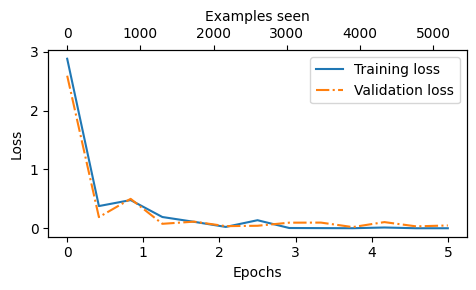

In [143]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    """
    Plots training and validation values against epochs and examples seen.

    Parameters:
    - epochs_seen: Tensor or list of epochs.
    - examples_seen: Tensor or list of examples seen.
    - train_values: List of training values (e.g., losses or accuracies).
    - val_values: List of validation values (e.g., losses or accuracies).
    - label: Label for the y-axis and legend (default is "loss").
    """
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation values against epochs
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Create a second x-axis for examples seen
    ax2 = ax1.twiny()
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    # Adjust layout to make room
    fig.tight_layout()
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

# Generate tensors for epochs and examples seen
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

# Plot the values
plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

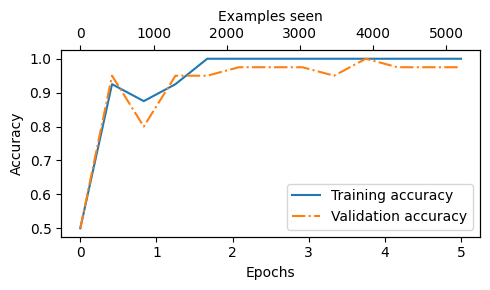

In [144]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs,
            label="accuracy")

In [145]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 100.00%
Validation accuracy: 98.66%
Test accuracy: 97.33%


##### Using the LLM as a spam classifier

In [147]:
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    """
    Classifies a given text as 'spam' or 'not spam' using the provided model.

    Parameters:
    - text: The input text to classify.
    - model: The trained classification model.
    - tokenizer: The tokenizer to encode the text.
    - device: The device (CPU or GPU) to run the model on.
    - max_length: The maximum length of the input sequence (optional).
    - pad_token_id: The token ID used for padding (default is 50256).

    Returns:
    - 'spam' if the predicted label is 1, otherwise 'not spam'.
    """
    model.eval()  # Set the model to evaluation mode

    # Prepare inputs to the model
    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[1]

    # Truncate sequences if they are too long
    if max_length is None:
        max_length = supported_context_length
    input_ids = input_ids[:min(max_length, supported_context_length)]

    # Pad sequences to the maximum length
    input_ids += [pad_token_id] * (max_length - len(input_ids))
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0)  # Add batch dimension

    # Perform inference
    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]
        predicted_label = torch.argmax(logits, dim=-1).item()

    return "spam" if predicted_label == 1 else "not spam"

In [149]:
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.")

print(classify_review(
    text_1, model, tokenizer, device, max_length=train_dataset.max_length))

spam


In [150]:
text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!")

print(classify_review(
text_2, model, tokenizer, device, max_length=train_dataset.max_length))

not spam


In [151]:
torch.save(model.state_dict(), "review_classifier.pth")

In [153]:
model_state_dict = torch.load("review_classifier.pth", map_location=device)
model.load_state_dict(model_state_dict)

<All keys matched successfully>

### Summary

- There are different strategies for fine-tuning LLMs, including classification fine-tuning and instruction fine-tuning.  
- Classification fine-tuning involves replacing the output layer of an LLM with a small classification layer.  
- In the case of classifying text messages as “spam” or “not spam,” the new classification layer consists of only two output nodes. Previously, the number of output nodes was equal to the number of unique tokens in the vocabulary (i.e., 50,256).  
- Instead of predicting the next token in the text as in pretraining, classification fine-tuning trains the model to output a correct class label—for example, “spam” or “not spam.”  
- The model input for fine-tuning is text converted into token IDs, similar to pretraining.  
- Before fine-tuning an LLM, we load the pretrained model as a base model.  
- Evaluating a classification model involves calculating the classification accuracy (the fraction or percentage of correct predictions).  
- Fine-tuning a classification model uses the same cross-entropy loss function as when pretraining the LLM.  


## Fine-tuning to follow instructions

In [155]:
import json
import os
import urllib.request

def download_and_load_file(file_path, url):
    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    else:
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()
    data = json.loads(text_data)
    return data

file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


In [156]:
print("Example entry:\n", data[50])

Example entry:
 {'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}


In [157]:
print("Another example entry:\n", data[999])

Another example entry:
 {'instruction': "What is an antonym of 'complicated'?", 'input': '', 'output': "An antonym of 'complicated' is 'simple'."}


In [158]:
# Implementing the prompt formatting function 
def format_input(entry):
    instruction_text = (
    f"Below is an instruction that describes a task. "
    f"Write a response that appropriately completes the request."
    f"\n\n### Instruction:\n{entry['instruction']}"
    )
    input_text = (
        f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""
        )
    return instruction_text + input_text

In [159]:
model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"
print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


In [161]:
model_input = format_input(data[999])
desired_response = f"\n\n### Response:\n{data[999]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is an antonym of 'complicated'?

### Response:
An antonym of 'complicated' is 'simple'.


In [163]:
# Partitioning the dataset
train_portion = int(len(data) * 0.85)
test_portion = int(len(data) * 0.1)
val_portion = len(data) - train_portion - test_portion
train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


##### Organizing data into training batches

In [166]:
import torch
from torch.utils.data import Dataset

class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.encoded_texts = []
        # Pretokenizes texts
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

In [167]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [ ]:
def custom_collate_draft_1(batch, pad_token_id=50256, device="cpu"):
    # Finds the longest sequence in the batch
    batch_max_length = max(len(item) + 1 for item in batch)
    inputs_lst = []
    
    for item in batch:
        # Pads and prepares inputs
        new_item = item.copy()
        new_item += [pad_token_id]
        padded = new_item + [pad_token_id] * (batch_max_length - len(new_item))
        inputs = torch.tensor(padded[:-1])
        inputs_lst.append(inputs)
    
    inputs_tensor = torch.stack(inputs_lst).to(device)
    return inputs_tensor


In [169]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]
batch = (
    inputs_1,
    inputs_2,
    inputs_3
    )

print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


In [ ]:
def custom_collate_draft_2(batch, pad_token_id=50256, device="cpu"):
    batch_max_length = max(len(item) + 1 for item in batch)
    inputs_lst, targets_lst = [], []
    
    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]
        
        # Padding the sequence
        padded = new_item + [pad_token_id] * (batch_max_length - len(new_item))
        
        # Truncate the last token for inputs
        inputs = torch.tensor(padded[:-1])
        
        # Shift +1 to the right for targets
        targets = torch.tensor(padded[1:])
        
        inputs_lst.append(inputs)
        targets_lst.append(targets)
    
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    
    return inputs_tensor, targets_tensor

# Example usage
inputs, targets = custom_collate_draft_2(batch)
print(inputs)
print(targets)


tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


In [171]:
# Implementing a custom batch collate function
def custom_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):
    batch_max_length = max(len(item) + 1 for item in batch)
    inputs_lst, targets_lst = [], []
    
    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index
        
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]
        
        inputs_lst.append(inputs)
        targets_lst.append(targets)
    
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    
    return inputs_tensor, targets_tensor

In [172]:
inputs, targets = custom_collate_fn(batch)

print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


In [173]:
logits_1 = torch.tensor(
    [[-1.0, 1.0],
    [-0.5, 1.5]]
    )
targets_1 = torch.tensor([0, 1]) # Correct token indices to generate
loss_1 = torch.nn.functional.cross_entropy(logits_1, targets_1)
    
print(loss_1)

tensor(1.1269)


In [175]:
logits_2 = torch.tensor(
    [[-1.0, 1.0],
    [-0.5, 1.5],
    [-0.5, 1.5]]
    )
targets_2 = torch.tensor([0, 1, 1])
loss_2 = torch.nn.functional.cross_entropy(logits_2, targets_2)

print(loss_2)

tensor(0.7936)


In [176]:
targets_3 = torch.tensor([0, 1, -100])
loss_3 = torch.nn.functional.cross_entropy(logits_2, targets_3)

print(loss_3)
print("loss_1 == loss_3:", loss_1 == loss_3)

tensor(1.1269)
loss_1 == loss_3: tensor(True)


In [177]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# if torch.backends.mps.is_available():
# device = torch.device("mps")"
print("Device:", device)

Device: cpu


In [178]:
from functools import partial

customized_collate_fn = partial(
custom_collate_fn,
device=device,
allowed_max_length=1024
)

In [180]:
# Initializing the data loaders
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8
torch.manual_seed(123)
train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
    )

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
    )

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
    )

In [182]:
print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

Train loader:
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 83]) torch.Size([8, 83])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 68]) torch.

##### Loading a pretrained LLM

In [193]:
# Reuse the existing imports and definitions for GPTModel and load_weights_into_gpt
BASE_CONFIG = {
    "vocab_size": 50257,  # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,  # Dropout rate
    "qkv_bias": True  # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")

# Reuse the download_and_load_gpt2 function from cell index 18
settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
)

# Reuse the GPTModel and load_weights_into_gpt from cell index 18
model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 27.0kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 1.20MiB/s]
hparams.json: 100%|██████████| 91.0/91.0 [00:00<00:00, 50.1kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 1.42G/1.42G [05:49<00:00, 4.06MiB/s] 
model.ckpt.index: 100%|██████████| 10.4k/10.4k [00:00<00:00, 6.98MiB/s]
model.ckpt.meta: 100%|██████████| 927k/927k [00:01<00:00, 776kiB/s] 
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 505kiB/s]  


GPTModel(
  (tok_emb): Embedding(50257, 1024)
  (pos_emb): Embedding(1024, 1024)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=1024, out_features=1024, bias=True)
        (W_key): Linear(in_features=1024, out_features=1024, bias=True)
        (W_value): Linear(in_features=1024, out_features=1024, bias=True)
        (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU()
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_feature

In [194]:
torch.manual_seed(123)
input_text = format_input(val_data[0])

print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [205]:
token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
    )
generated_text = token_ids_to_text(token_ids, tokenizer)

In [206]:
response_text = generated_text[len(input_text):].strip()

print(response_text)

### Response:

The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: 'The chef cooks the


In [213]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    
    # Ensure input and target tensors have the same batch size
    if input_batch.shape[0] != target_batch.shape[0]:
        raise ValueError(f"Input batch size ({input_batch.shape[0]}) does not match target batch size ({target_batch.shape[0]}).")
    
    logits = model(input_batch)[:, :-1, :]  # Logits for all tokens except the last
    target_batch = target_batch[:, 1:]  # Shift target tokens to align with logits
    
    # Flatten logits and target tensors for cross-entropy loss
    logits = logits.reshape(-1, logits.size(-1))
    target_batch = target_batch.reshape(-1)
    
    loss = torch.nn.functional.cross_entropy(logits, target_batch, ignore_index=-100)
    return loss

In [214]:
model.to(device)
torch.manual_seed(123)
with torch.no_grad():
    train_loss = calc_loss_loader(
        train_loader, model, device, num_batches=5
    )
    val_loss = calc_loss_loader(
        val_loader, model, device, num_batches=5
    )
    print("Training loss:", train_loss)
    print("Validation loss:", val_loss)

Training loss: 9.561110305786134
Validation loss: 9.673491287231446


In [215]:
# Instruction fine-tuning the pretrained LLM
import time
start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(
model.parameters(), lr=0.00005, weight_decay=0.1
)
num_epochs = 2
train_losses, val_losses, tokens_seen = train_model_simple(
model, train_loader, val_loader, optimizer, device,
num_epochs=num_epochs, eval_freq=5, eval_iter=5,
start_context=format_input(val_data[0]), tokenizer=tokenizer
)
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 7.396, Val loss 7.392
Below is an instruction that describes a task. Write a response that appropriately completes the request.  ### Instruction: Convert the active sentence to passive: 'The chef cooks the meal every day.'  ### Response: The chef cooks the meal every day.  ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### 
Ep 1 (Step 000005): Train loss 4.410, Val loss 4.403
Below is an instruction that describes a task. Write a response that appropriately completes the request.  ### Instruction: Convert the active sentence to passive: 'The chef cooks the meal every day.'  ###: : : : : : : : : : : : : : : : : : : : : : : :
Ep 1 (Step 000010): Train loss 2.800, Val loss 2.879
Below is an instruction that describes a task. Write a response that appropriately completes the request.  ### Instruction: Convert the active sentence to passive: 'The chef cooks the meal every day.' ###:The the the the the the the the the the the the the the the th

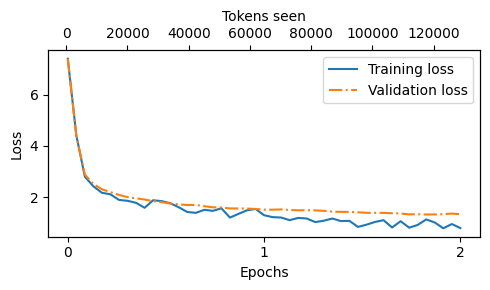

In [216]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

##### Extracting and saving responses

In [217]:
torch.manual_seed(123)
for entry in test_data[:3]:
    input_text = format_input(entry)
    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
        )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )

print(input_text)
print(f"\nCorrect response:\n>> {entry['output']}")
print(f"\nModel response:\n>> {response_text.strip()}")
print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

Correct response:
>> Jane Austen.

Model response:
>> ###:The of Pride and Prejud is. by.
###:The of is. by.
-------------------------------------


In [218]:
# Generating test set responses
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):
    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
        )
generated_text = token_ids_to_text(token_ids, tokenizer)

response_text = (
    generated_text[len(input_text):]
    .replace("### Response:", "")
    .strip()
    )
test_data[i]["model_response"] = response_text

with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4)

100%|██████████| 110/110 [14:40<00:00,  8.01s/it] 


In [219]:
print(test_data[0])

{'instruction': 'Rewrite the sentence using a simile.', 'input': 'The car is very fast.', 'output': 'The car is as fast as lightning.'}


In [220]:
import re

file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth"
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")

Model saved as gpt2-medium355M-sft.pth


## Summary

The instruction-fine-tuning process adapts a pretrained LLM to follow human instructions and generate desired responses.

- **Dataset Preparation**  
  Preparing the dataset involves downloading an instruction-response dataset, formatting the entries, and splitting it into train, validation, and test sets.

- **Batch Construction**  
  Training batches are constructed using a custom collate function that pads sequences, creates target token IDs, and masks padding tokens.

- **Model Initialization**  
  We load a pretrained GPT-2 medium model with 355 million parameters to serve as the starting point for instruction fine-tuning.

- **Fine-Tuning Process**  
  The pretrained model is fine-tuned on the instruction dataset using a training loop similar to pretraining.

- **Evaluation**  
  Evaluation involves extracting model responses on a test set and scoring them (for example, using another LLM).

- **Scoring with Ollama**  
  The Ollama application with an 8-billion-parameter Llama model can be used to automatically score the fine-tuned model’s responses on the test set, providing an average score to quantify performance.


### End of the notebook